In [36]:
import torch
import cv2
import os

import albumentations as A
import pandas as pd

from pathlib import Path
from albumentations.pytorch import ToTensorV2

def is_interactive():
    return os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive'
#     return True

def mem_usage():
    # CUDA Memory Usage in GB
    return torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0

def Normalize(**kwargs):
    kwargs['image'] = (kwargs['image'] / 255.).astype('float32')
    return kwargs

def ToChannels(channels):
    def fn(**kwargs):
        im = kwargs['image']
        
        if channels == 1:
            kwargs['image'] = np.expand_dims(im, -1)
        else:
            kwargs['image'] = np.stack([im]*channels, axis=-1)
        return kwargs
    return fn

class Config(object):
    seed = 42
    root = Path('.')
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    groups_df = pd.read_csv(root / 'gt.csv')
    
    def __init__(
        self,
        epochs=15,
        batch_sizes={'train': 16, 'valid': 32},
        allow_empty=True,
        groups=dict(train=["kidney_1_dense"], valid=["kidney_3_dense"]),
        resolution=224,
        channels=3,
        pretrained=True,
        lr=1e-4,
        patience=2,
        min_lr=0.00001,
        lr_decay=0.75,
    ):
        self.epochs = epochs
        self.batch_sizes = batch_sizes
        
        self.groups = groups
        self.allow_empty = allow_empty
        
        self.input_shape = [resolution, resolution]
        self.channels = channels
        self.pretrained = pretrained
        
        self.lr = lr
        self.patience = patience
        self.min_lr = min_lr
        self.lr_decay = lr_decay
        
        self.transforms = {
            'train': A.Compose([
                A.Resize(*self.input_shape, p=1.0),
                A.RandomBrightnessContrast(p=0.2),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                Normalize,
                ToChannels(self.channels),
                ToTensorV2(),
            ]),

            'valid': A.Compose([
                A.Resize(*self.input_shape, p=1.0),
                Normalize,
                ToChannels(self.channels),
                ToTensorV2(),
            ]),
        }
        
    def __repr__(self):
        return (
            f'\n{self.seed=}'
            f'\n{self.root=}'
            f'\n{self.device=}'
            f'\n{self.lr=}'
            f'\n{self.patience=}'
            f'\n{self.min_lr=}'
            f'\n{self.lr_decay=}'
            f'\n{self.epochs=}'
            f'\n{self.batch_sizes=}'
            f'\n{self.groups=}'
            f'\n{self.channels=}'
            f'\n{self.pretrained=}'
            f'\n{self.input_shape=}'
        )

kwargs = {}
if is_interactive():
    kwargs = dict(epochs=2)
    
config = Config(
    channels=1, pretrained=False,
    resolution=512,
    epochs=70,
    lr=1e-3,
    patience=4,
    lr_decay=0.8,
    batch_sizes={'train': 12, 'valid': 12},
#     batch_sizes={'train': 64, 'valid': 64},
    **kwargs
)

display(config.groups_df.head(10))

config, len(config.groups_df)

,id,rle,group,slice,height,width,img_path,msk_path
0,kidney_1_dense_0000,1 0,kidney_1_dense,0,1303,912,blood-vessel-segmentation/train/kidney_1_dense...,blood-vessel-segmentation/train/kidney_1_dense...
1,kidney_1_dense_0001,1 0,kidney_1_dense,1,1303,912,blood-vessel-segmentation/train/kidney_1_dense...,blood-vessel-segmentation/train/kidney_1_dense...
2,kidney_1_dense_0002,1 0,kidney_1_dense,2,1303,912,blood-vessel-segmentation/train/kidney_1_dense...,blood-vessel-segmentation/train/kidney_1_dense...
3,kidney_1_dense_0003,1 0,kidney_1_dense,3,1303,912,blood-vessel-segmentation/train/kidney_1_dense...,blood-vessel-segmentation/train/kidney_1_dense...
4,kidney_1_dense_0004,1 0,kidney_1_dense,4,1303,912,blood-vessel-segmentation/train/kidney_1_dense...,blood-vessel-segmentation/train/kidney_1_dense...
5,kidney_1_dense_0005,1 0,kidney_1_dense,5,1303,912,blood-vessel-segmentation/train/kidney_1_dense...,blood-vessel-segmentation/train/kidney_1_dense...
6,kidney_1_dense_0006,1 0,kidney_1_dense,6,1303,912,blood-vessel-segmentation/train/kidney_1_dense...,blood-vessel-segmentation/train/kidney_1_dense...
7,kidney_1_dense_0007,1 0,kidney_1_dense,7,1303,912,blood-vessel-segmentation/train/kidney_1_dense...,blood-vessel-segmentation/train/kidney_1_dense...
8,kidney_1_dense_0008,1 0,kidney_1_dense,8,1303,912,blood-vessel-segmentation/train/kidney_1_dense...,blood-vessel-segmentation/train/kidney_1_dense...
9,kidney_1_dense_0009,1 0,kidney_1_dense,9,1303,912,blood-vessel-segmentation/train/kidney_1_dense...,blood-vessel-segmentation/train/kidney_1_dense...


(
 self.seed=42
 self.root=PosixPath('.')
 self.device=device(type='cpu')
 self.lr=0.001
 self.patience=4
 self.min_lr=1e-05
 self.lr_decay=0.8
 self.epochs=70
 self.batch_sizes={'train': 12, 'valid': 12}
 self.groups={'train': ['kidney_1_dense'], 'valid': ['kidney_3_dense']}
 self.channels=1
 self.pretrained=False
 self.input_shape=[512, 512],
 7429)

In [37]:
import segmentation_models_pytorch as smp

def build_model(config):
    model = smp.Unet(
        encoder_name='timm-mobilenetv3_small_100',
#         encoder_name='resnet34',      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=1,
        classes=1,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(config.device)
    return model

model = build_model(config)

In [38]:
from matplotlib import pyplot as plt

def make_grid_plot(num_items, cols=3, size=3):
    rows = (num_items + cols - 1)//cols
    cols = min(cols, num_items)
    
    fig, axes = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    axes = axes.flatten() if cols > 1 else [axes]
    
    fig.tight_layout()
    
    return fig, axes

(<matplotlib.image.AxesImage at 0x2b284e170>, (463, 703, 3))

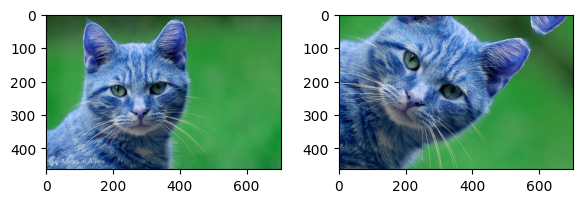

In [39]:
import cv2

import albumentations as A


image = cv2.imread('cat.jpeg', cv2.IMREAD_UNCHANGED)
# input_shape = [512, 512]
input_shape = [256, 256]

_, axes = make_grid_plot(2)

axes[0].imshow(image)

# aug = A.RandomResizedCrop(
#     *input_shape,
#     scale=(.1, .2),
#     # ratio=(1.0, 1.0),
#     interpolation=cv2.INTER_NEAREST,
#     p=1.0,
# )
aug = A.ShiftScaleRotate(
    # shift_limit=0, rotate_limit=0,
    scale_limit=.4,
    interpolation=cv2.INTER_LINEAR,
    p=1.0,
)
# aug = A.RandomScale(scale_limit=.5, p=1.0)
# aug = A.RandomCrop(*input_shape)

aug_image = aug(image=image)['image']

axes[1].imshow(aug_image), aug_image.shape

# Dice Metric

In [40]:
def get_dice(y_pred_classes, y, eps=1e-8):
    y_pred_classes = y_pred_classes.float()
    intersection = (y_pred_classes*y).sum()
    union = (y_pred_classes+y).sum()
    return ((2*intersection + eps)/(union + eps)).cpu().item()

batch_shape = (2, config.channels, *config.input_shape)
y_pred = (torch.randn(*batch_shape) > 0.5).type(torch.float32)
y = (torch.randn(*batch_shape) > 0.5).type(torch.uint8)

get_dice(y_pred, y)

0.30992937088012695

In [41]:
import pickle

metrics = {
    'dice_score': [0.003923559933927091, 0.925687018821114],
    'loss': [0.3151379159406612, 0.002288523606196242],
    'valid_dice_score': [1.4577377339498346e-12, 0.4946871513412112],
    'valid_loss': [0.12292786226386115, 0.00661514383474631]
}

with open('metric.pickle', 'wb') as f:
    pickle.dump(metrics, f)

In [42]:
with open('metric.pickle', 'rb') as f:
    metrics = pickle.load(f)
    print(metrics)

{'dice_score': [0.003923559933927091, 0.925687018821114], 'loss': [0.3151379159406612, 0.002288523606196242], 'valid_dice_score': [1.4577377339498346e-12, 0.4946871513412112], 'valid_loss': [0.12292786226386115, 0.00661514383474631]}


In [43]:
import torch

def get_tile_corners(length, tile_size, stride):
    corners = torch.cat([
        torch.arange(0, length-tile_size, step=stride),
        torch.tensor([length-tile_size]),
    ])

    # Trim edges if we can afford to throw some tiles away.
    return corners[1:-1] if corners.numel() >= 5 else corners

length, size, stride = 1041, 512, 256

get_tile_corners(length, size, stride), 1041-768, 768+512, 1041-512

(tensor([  0, 256, 512, 529]), 273, 1280, 529)

In [44]:
import itertools

import numpy as np

from matplotlib import pyplot as plt

def make_grid_plot(num_items, cols=3, size=3, gridspec={'wspace': 0, 'hspace': 0}, titles=[]):
    # Compute rows and columns
    num_items = 1 if not num_items else num_items
    rows = (num_items + cols - 1)//cols
    cols = min(cols, num_items)
    
    # Create axes
    fig, axes = plt.subplots(
        rows, cols,
        figsize=(size*cols, size*rows),
        gridspec_kw=gridspec
    )

    # Set row and column titles
    title_fn = np.vectorize(lambda ax, title: ax.set_title(title))
    title_fn(axes if rows == 1 else axes[0], titles + ['']*max(0, cols - len(titles)))

    # Flatten axes for easy iteration
    axes = axes.flatten() if num_items > 1 else [axes]
    
    fig.tight_layout()
    
    return fig, axes

def show_items(
    items, item_ids=[],
    cols=2, size=2, cmap='gray',
    titles=[''], item_fn=lambda x:x,
):
    # Initialize item_ids if not passed in.
    item_ids = list(range(len(items))) if not item_ids else item_ids
    
    # Make a 2-D plot to lay items
    fig, axes = make_grid_plot(
        len(item_ids)*cols,
        cols=cols, size=size,
        titles=titles
    )

    # Clean axes
    for ax in axes: ax.axis("off")

    item_sequence = itertools.chain.from_iterable(
        map(lambda idx: item_fn(items[idx]), item_ids)
    )
    for ax_id, item in enumerate(item_sequence):
        axes[ax_id].imshow(item, cmap=cmap)

    fig.tight_layout()
    
    return fig

In [45]:
import numpy as np
from pathlib import Path

sample_names = np.fromiter(
    map(
        lambda x: f'{x:04d}.tif',
        [6, 85, 98, 329, 1049, 1439, 1679, 1979, 2189, 2272]
    ),
    dtype=object,
)
base = './'
image_names = base + 'images/' + sample_names
mask_names = base + 'masks/' + sample_names

vPath = np.vectorize(Path)
image_paths = vPath(image_names)
mask_paths = vPath(mask_names)

image_paths, mask_paths

(array([PosixPath('images/0006.tif'), PosixPath('images/0085.tif'),
        PosixPath('images/0098.tif'), PosixPath('images/0329.tif'),
        PosixPath('images/1049.tif'), PosixPath('images/1439.tif'),
        PosixPath('images/1679.tif'), PosixPath('images/1979.tif'),
        PosixPath('images/2189.tif'), PosixPath('images/2272.tif')],
       dtype=object),
 array([PosixPath('masks/0006.tif'), PosixPath('masks/0085.tif'),
        PosixPath('masks/0098.tif'), PosixPath('masks/0329.tif'),
        PosixPath('masks/1049.tif'), PosixPath('masks/1439.tif'),
        PosixPath('masks/1679.tif'), PosixPath('masks/1979.tif'),
        PosixPath('masks/2189.tif'), PosixPath('masks/2272.tif')],
       dtype=object))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

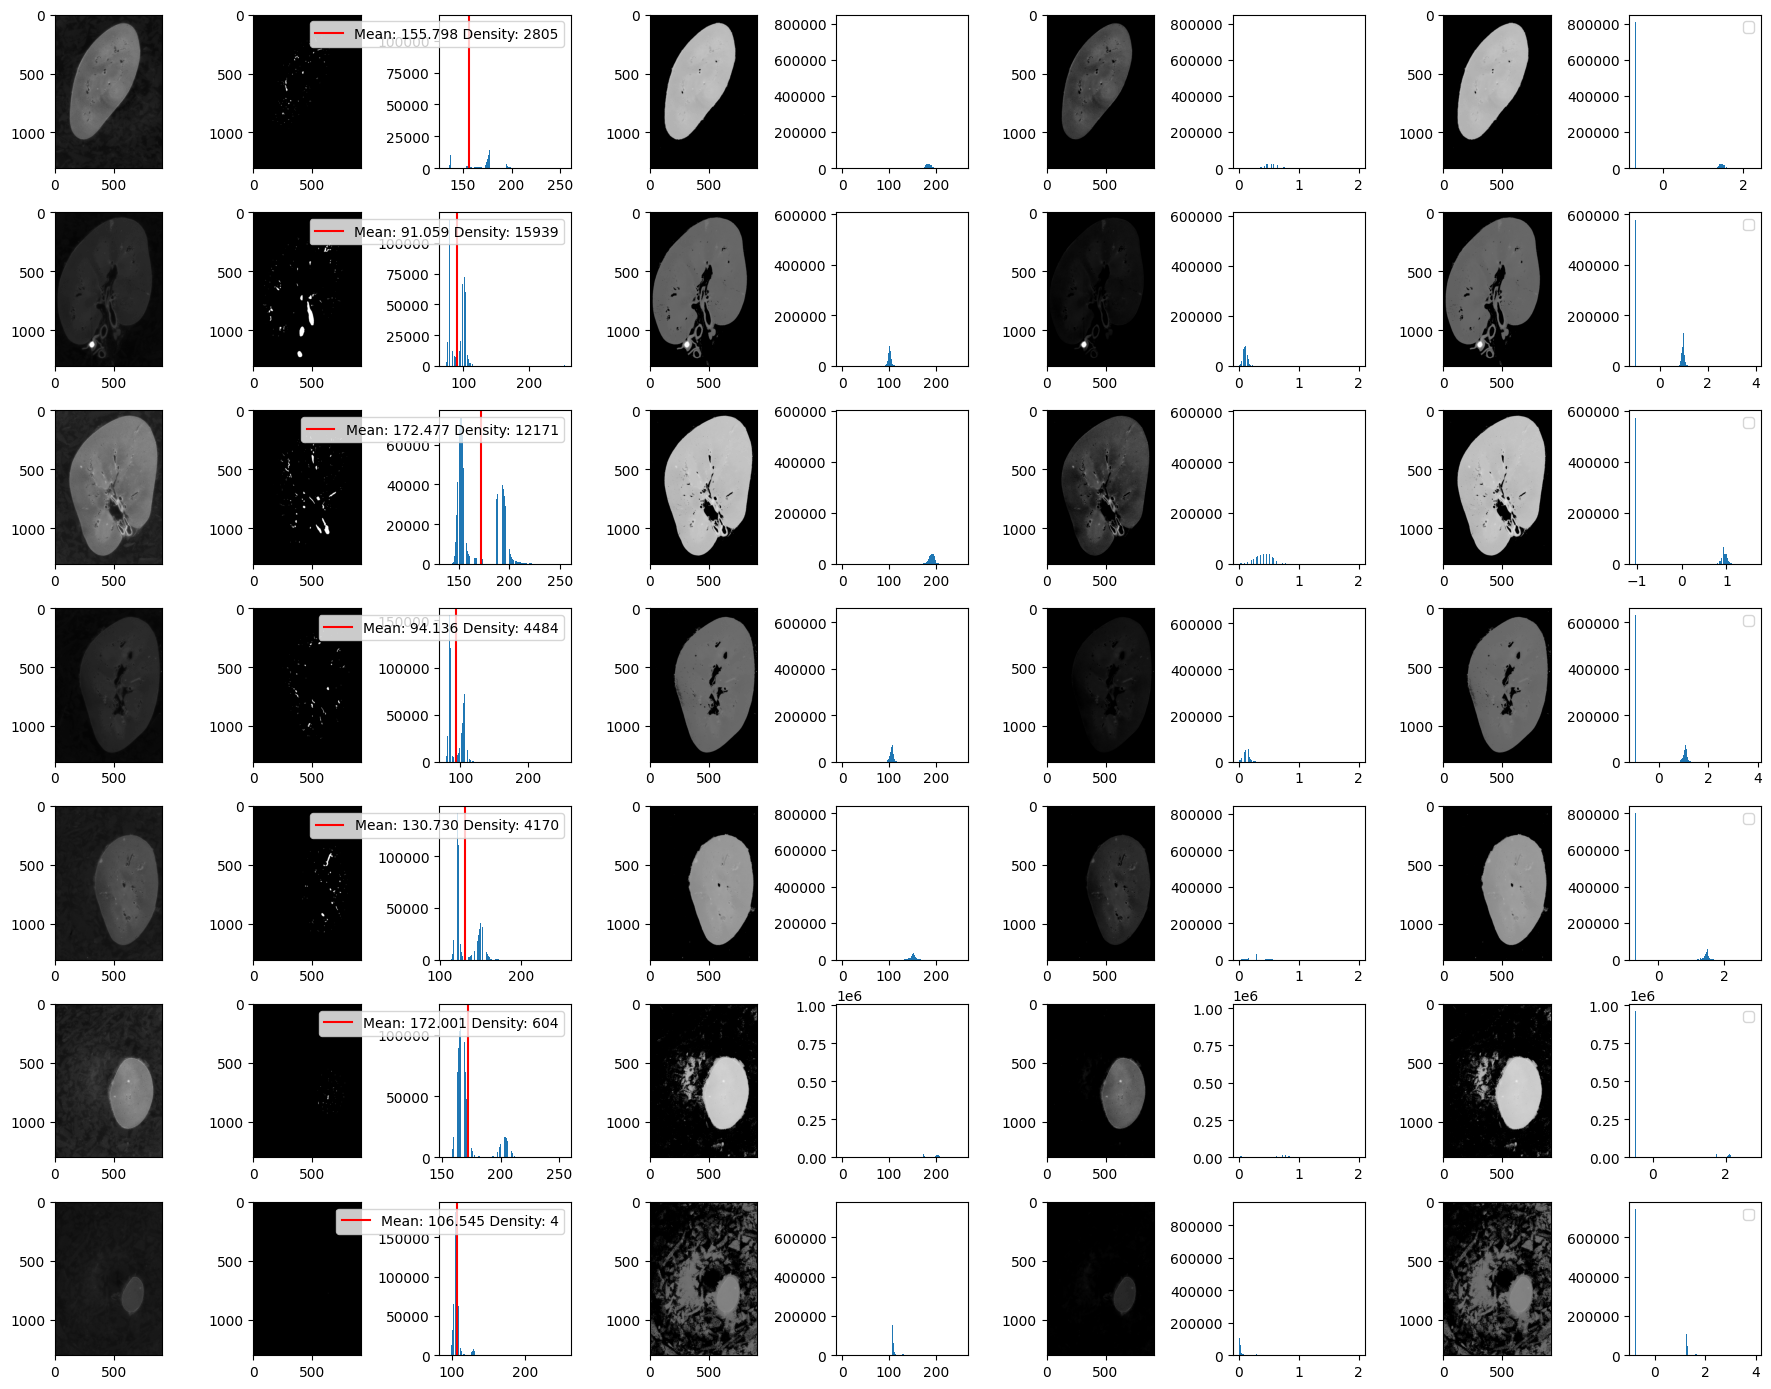

In [46]:
from matplotlib import pyplot as plt

def make_grid_plot(num_items, cols=3, size=3, gridspec={}, titles=[]):
    # Compute rows and columns
    num_items = 1 if not num_items else num_items
    rows = (num_items + cols - 1)//cols
    cols = min(cols, num_items)
    
    # Create axes
    fig, axes = plt.subplots(
        rows, cols,
        figsize=(size*cols, size*rows),
        gridspec_kw=gridspec
    )

    # Set row and column titles
    title_fn = np.vectorize(lambda ax, title: ax.set_title(title))
    title_fn(axes if rows == 1 else axes[0], titles + ['']*max(0, cols - len(titles)))

    # Flatten axes for easy iteration
    axes = axes.flatten() if num_items > 1 else [axes]
    
    fig.tight_layout()
    
    return fig, axes

def show_items(items, cols=2, titles=[], size=3):
    fig, axes = make_grid_plot(
        len(items)*cols,
        cols=cols, size=size,
        gridspec={'wspace': 0, 'hspace': 0}
    )
    
    for ax in axes: ax.axis("off")
    for item_idx, item in enumerate(items):
        for elem_idx, elem in enumerate(item):
            if len(elem.shape) == 3:
                elem = elem.permute(1, 2, 0)
                
            if titles:
                axes[item_idx*cols].set_title(titles[item_idx])
            
            axes[item_idx*cols + elem_idx].imshow(elem)
    
    fig.tight_layout()
    
    return fig

import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

def loadimage(p):
    image = np.array(Image.open(p))
    image = ((image / np.max(image))*255).astype(np.uint8)

    return image

def loadmask(p):
    mask = np.array(Image.open(p))
    mask = (mask > 0).astype(np.uint8)
    return mask

def plot_sample(axes, image, mask, cmap=None, title=None):
    axes[0].imshow(image, cmap=cmap)
    axes[1].imshow(mask, cmap=cmap)

    axes[2].hist(image.reshape(-1), bins=255)
    axes[2].axvline(image.mean(), color='red', label=f'Mean: {image.mean():.3f} Density: {mask.sum()}')
    axes[2].legend()

    mean_truncated_image = image
    mean_truncated_image[mean_truncated_image < image.mean()] = 0
    truncated_image_mean = mean_truncated_image.sum() / (mean_truncated_image != 0).astype('uint8').sum()

    axes[3].imshow(mean_truncated_image, cmap=cmap)
    axes[4].hist(mean_truncated_image.reshape(-1), bins=255)
    # axes[4].axvline(truncated_image_mean, color='red', label=f'Mean: {truncated_image_mean:.3f}')
    # axes[4].legend()


    eps = 1e-8
    minval = mean_truncated_image[mean_truncated_image.nonzero()].min()
    maxval = mean_truncated_image.max()
    
    mean_adjusted_image = (mean_truncated_image.astype('float32') - minval) / (maxval - minval + eps)*2
    mean_adjusted_image[mean_adjusted_image < 0.] = 0
    
    axes[5].imshow(mean_adjusted_image, cmap=cmap)
    axes[6].hist(mean_adjusted_image.reshape(-1), bins=255)

    standardized_image = (image - image.mean()) / image.std()
    standardized_image_mean = standardized_image.sum() / (standardized_image != 0).astype('uint8').sum()

    axes[7].imshow(standardized_image, cmap=cmap)
    axes[8].hist(standardized_image.reshape(-1), bins=255)
    # axes[6].axvline(standardized_image_mean, color='red', label=f'Mean: {standardized_image_mean:.3f}')
    axes[8].legend()


    # mask = (mask > 0).astype('uint8')
    # non_zero_mask_indices, = np.nonzero(mask.reshape(-1))
    
    # axes[3].scatter(range(image.size), image.reshape(-1))
    # axes[3].scatter(non_zero_mask_indices, (image*mask).reshape(-1)[non_zero_mask_indices])

    # title_fn = np.vectorize(lambda ax, title: ax.set_title(title))
    # title_fn(axes, title)

def load_and_plot_samples(image_paths, mask_paths):
    image_vfn = np.frompyfunc(loadimage, 1, 1)
    mask_vfn = np.frompyfunc(loadmask, 1, 1)

    images, masks = image_vfn(image_paths), mask_vfn(mask_paths)

    cols = 9
    _, axes = make_grid_plot(
        len(images)*cols, cols=cols, size=2,
        # titles=['Image', 'Mask', 'Intensities'],
    )
    ax_chunks = np.split(axes, len(images))

    for ax_chunk, image, mask in zip(ax_chunks, images, masks):
        plot_sample(ax_chunk, image, mask, cmap='gray')
    
    plt.show()


# # image = loadimage(image_paths[1])

# # plt.imshow(image, cmap='gray')
# _, axes = make_grid_plot(len(image_paths)*3, cols=3, titles=['Image', 'Mask', 'Intensities'])

# # _, axes = make_grid_plot(2)

# image = loadimage(image_paths[1])
# mask = loadimage(mask_paths[1])

# plot_sample(axes[0:4], image, mask, cmap='gray')

# plt.subplot()
# mask = (mask > 0).astype('uint8')
# non_zero_mask_indices, = np.nonzero(mask.reshape(-1))

# # plt.scatter(range(image.size), image.reshape(-1))
# plt.eventplot(non_zero_mask_indices, colors='orange')
# # plt.scatter(non_zero_mask_indices, (image*mask).reshape(-1)[non_zero_mask_indices])
# # plt.vlines(non_zero_mask_indices, 0, 255)

load_and_plot_samples(image_paths[3:], mask_paths[3:])
plt.show()


In [47]:
from collections import namedtuple

SplitConfig = namedtuple(
    'SplitConfig',
    ['name', 'batch', 'groups', 'transforms'],
    defaults=[None, 12, [], None]
)

split_configs = dict(
    train=SplitConfig(name='train', groups=['kidney_1_dense']),
    valid=SplitConfig(name='valid', groups=['kidney_3_dense']),
    test=SplitConfig(name='test', batch=1),
)

train_split_config = split_configs['train']
valid_split_config = split_configs['valid']
test_split_config = split_configs['test']

print(
    f'\n{train_split_config=}'
    f'\n{valid_split_config=}'
    f'\n{test_split_config=}'
)


train_split_config=SplitConfig(name='train', batch=12, groups=['kidney_1_dense'], transforms=None)
valid_split_config=SplitConfig(name='valid', batch=12, groups=['kidney_3_dense'], transforms=None)
test_split_config=SplitConfig(name='test', batch=1, groups=[], transforms=None)



10 (1303, 912) uint8
10 (1303, 912) uint8


/var/folders/8y/5694n0_n42j4fmg6d5j411480000gn/T/ipykernel_96821/1642221234.py:49: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


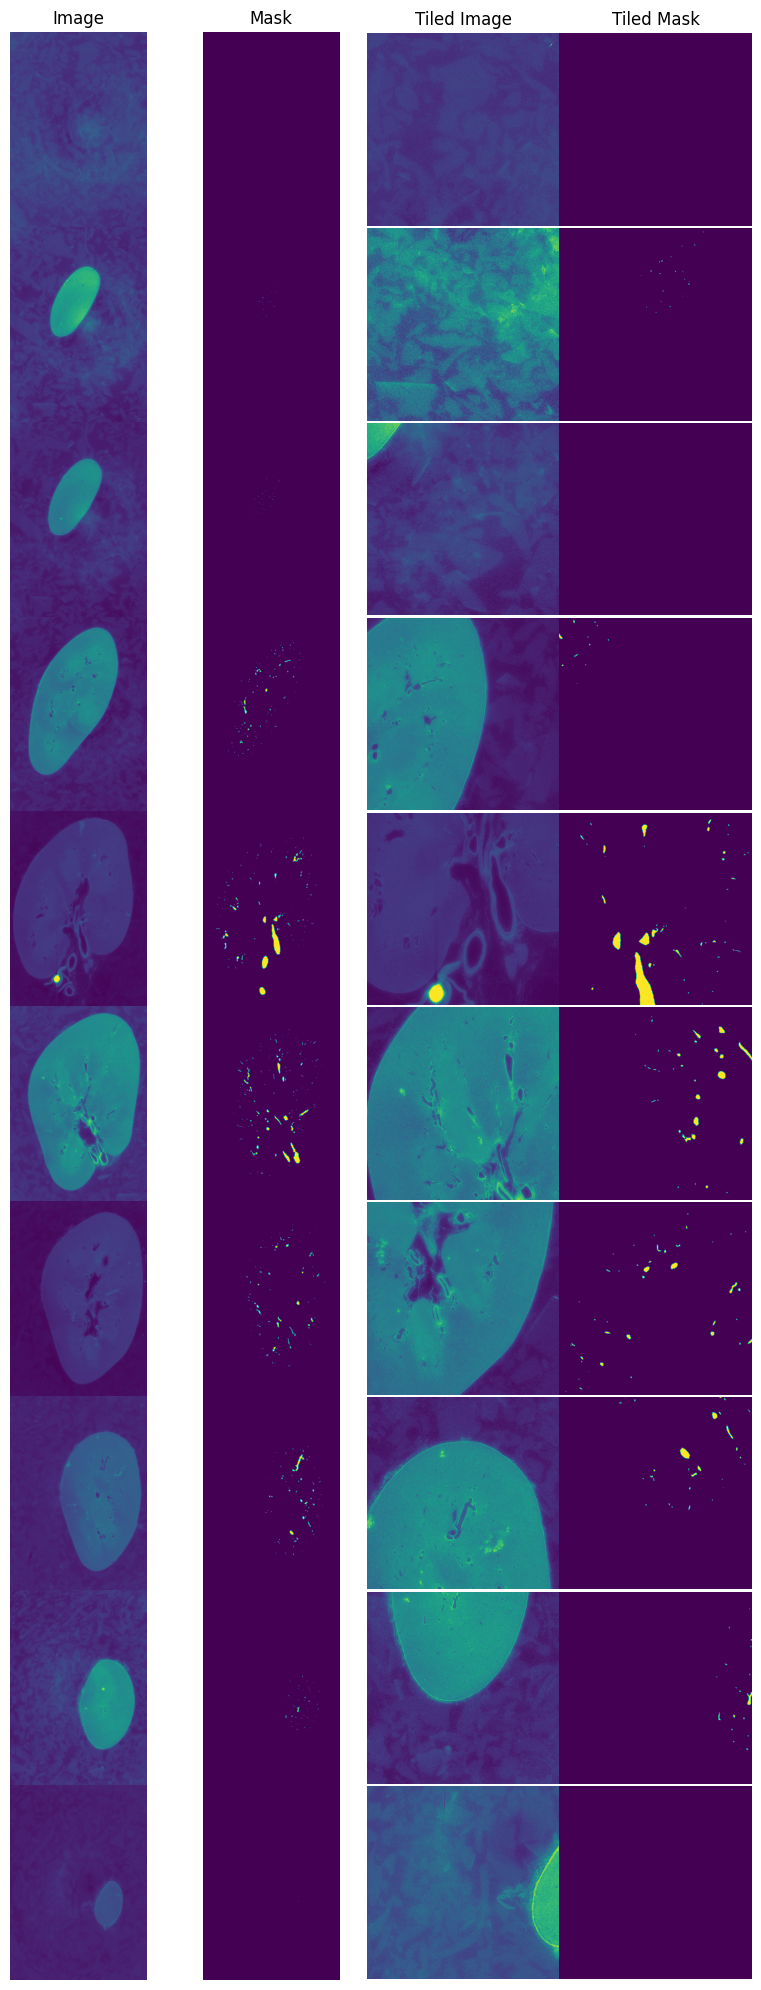

In [48]:
import itertools

import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

def make_grid_plot(num_items, cols=3, size=3, gridspec={'wspace': 0, 'hspace': 0}, titles=[]):
    # Compute rows and columns
    num_items = 1 if not num_items else num_items
    rows = (num_items + cols - 1)//cols
    cols = min(cols, num_items)
    
    # Create axes
    fig, axes = plt.subplots(
        rows, cols,
        figsize=(size*cols, size*rows),
        gridspec_kw=gridspec
    )

    # Set row and column titles
    title_fn = np.vectorize(lambda ax, title: ax.set_title(title))
    title_fn(axes if rows == 1 else axes[0], titles + ['']*max(0, cols - len(titles)))

    # Flatten axes for easy iteration
    axes = axes.flatten() if num_items > 1 else [axes]
    
    fig.tight_layout()
    
    return fig, axes

def show_items(items, item_ids=[0], cols=2, size=2, titles=[''], item_fn=lambda x:x,):
    # Make a 2-D plot to lay items
    fig, axes = make_grid_plot(
        len(item_ids)*cols,
        cols=cols, size=size,
        titles=titles
    )

    # Clean axes
    for ax in axes: ax.axis("off")

    item_sequence = itertools.chain.from_iterable(
        map(lambda idx: item_fn(items[idx]), item_ids)
    )
    for ax_id, item in enumerate(item_sequence):
        axes[ax_id].imshow(item)

    fig.tight_layout()

import numpy as np

@np.vectorize(signature='()->(m,n)')
def loadimage(p, eps=1e-8):
    image = np.array(Image.open(p))
    image = ((image / (eps + np.max(image)))*255).astype(np.uint8)

    return image

@np.vectorize(signature='()->(m,n)')
def loadmask(p):
    mask = np.array(Image.open(p))
    mask = (mask > 0).astype(np.uint8)
    return mask

import numpy as np
import albumentations as A

def ToBitmapMask(threshold=0):
    def fn(**kwargs):
        mask = kwargs['mask']
        mask = (mask > threshold).astype('uint8')
        kwargs['mask'] = mask
        return kwargs

    return fn

def ToTiles(size, channels, stride_factor, axis=-1, reduction='none'):
    stride = size // stride_factor

    def reduce_axis(x):
        if reduction == 'none': x = x
        elif reduction == 'sum': x = x.mean(axis=axis)
        else: x = x.mean(axis=axis)
        
        return x
    
    def get_corners(length):
        return np.concatenate([
            np.arange(0, length - size, step=stride),
            [length - size],
        ])
    
    def randpick(items):
        return items[np.random.randint(len(items), size=channels)]

    def random_corners(x):
        h, w = x.shape
        return (
            randpick(get_corners(h)),
            randpick(get_corners(w))
        )
    
    @np.vectorize(signature='(),()->(x,y)', excluded=[2])
    def tile_at(top, left, x):
        return x[top:top+size, left:left+size]
            
    def fn(image, **kwargs):
        tops, lefts = random_corners(image)
        return reduce_axis(
            np.stack(tile_at(tops, lefts, image), axis=axis)
        )

    return fn

transforms = A.Compose([
    A.Lambda(
        image=ToTiles(512, 1, stride_factor=4),
        mask=ToTiles(512, 1, stride_factor=4, reduction='sum'),
        always_apply=True
    ),
    ToBitmapMask(),
])

images = loadimage(image_paths)
masks = loadimage(mask_paths)

print(
    f'\n{len(images)} {images[0].shape} {images[0].dtype}'
    f'\n{len(masks)} {masks[0].shape} {masks[0].dtype}'
)

def get_item_fn(transforms):
    def fn(args):
        image, mask = args
        result = transforms(image=image, mask=mask)
        return image, mask, result['image'], result['mask']

    return fn

show_items(
    np.fromiter(
        map(get_item_fn(transforms), zip(images, masks)),
        dtype=object,
    ),
    # item_fn=lambda args: (a),
    item_ids=list(range(len(images))),
    titles=['Image', 'Mask', 'Tiled Image', 'Tiled Mask'],
    cols=4, size=2,
)

# transforms()
# input_id = 0
# image = loadimage(image_paths[input_id])
# mask = loadmask(mask_paths[input_id])

# result = transforms(image=image, mask=mask)

# result['image'].shape, result['mask'].shape

(1303, 912)


/var/folders/8y/5694n0_n42j4fmg6d5j411480000gn/T/ipykernel_96821/458915277.py:18: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


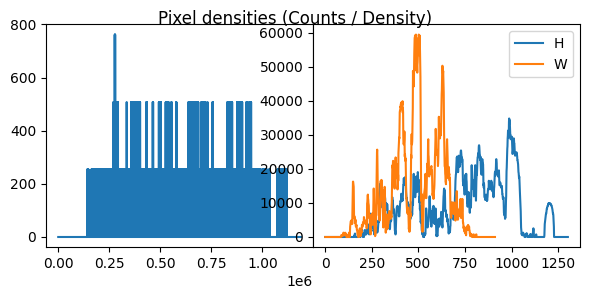

In [49]:
from functools import reduce

pixel_densities = {
    'train': reduce(
    lambda y,mask: y+mask,
    masks,
    np.zeros_like(masks[0], dtype=int)
)
}

fig, axes = make_grid_plot(2, cols=3)
for index, (name, densities) in enumerate(pixel_densities.items()):
    axes[index].plot(densities.reshape(-1,))
    axes[index+1].plot(densities.sum(axis=-1), label='H')
    axes[index+1].plot(densities.sum(axis=-2), label='W')
    axes[index+1].legend()
    
fig.tight_layout()
fig.suptitle('Pixel densities (Counts / Density)')

print(masks[0].shape)

In [50]:
import itertools

from albumentations.pytorch import ToTensorV2

def ToChannels(channels):
    def fn(**kwargs):
        im = kwargs['image']
        
        if channels == 1:
            kwargs['image'] = np.expand_dims(im, -1)
        else:
            kwargs['image'] = np.stack([im]*channels, axis=-1)
        return kwargs
    return fn

def ToFloatImage(standardize=True, eps=1e-8):
    def fn(**kwargs):
        image = kwargs['image']
        
        if standardize:
            image = ((image - image.mean()) / (image.std() + eps)).astype('float32')
        else:
            image = (image / 255.).astype('float32')
            
        kwargs['image'] = image
        return kwargs
    return fn

def ToBitmapMask(threshold=0):
    def fn(**kwargs):
        mask = kwargs['mask']
        mask = (mask > threshold).astype('uint8')
        kwargs['mask'] = mask
        return kwargs

    return fn

def get_dice(y_pred_classes, y, eps=1e-8, dim=None):
    y_pred_classes = y_pred_classes.float()
    intersection = (y_pred_classes*y).sum(dim=dim)
    union = (y_pred_classes+y).sum(dim=dim)
    score = ((2*intersection + eps)/(union + eps)).cpu()
    
    return score if dim is not None else score.item()

def predict_item(model, config, item):
    probabilities = model(item).sigmoid()
    return (probabilities > 0.5).type(torch.uint8).squeeze(dim=1)

def distribute(data, bins=[100]):
    # Compute cumulative membership and frequencies
    cumulative_frequencies, cumulative_memberships = [], []

    for b in bins:
        cumulative_bin_members = data < b
        cumulative_bin_frequency = cumulative_bin_members.to(torch.uint8).sum().item()

        cumulative_frequencies.append(cumulative_bin_frequency)
        cumulative_memberships.append(cumulative_bin_members)

    # Add initial and final boundaries
    cumulative_frequencies = torch.tensor(
        [0] + cumulative_frequencies + [data.numel()],
        device=data.device
    )

    # Add final bin members
    cumulative_memberships = [
        torch.zeros_like(data).to(torch.bool),
        *cumulative_memberships,
        torch.ones_like(data).to(torch.bool),
    ]

    # Membership bitmap
    memberships = torch.stack(
        list(map(
            lambda elems: ~elems[0]*elems[1],
            itertools.pairwise(cumulative_memberships)
        )),
        dim=0,
    )

    # Bin counts
    bin_counts = cumulative_frequencies[1:] - cumulative_frequencies[:-1]

    return bin_counts, memberships

def get_stats(
    model, config, loader,
    predict_fn=predict_item, score_fn=get_dice,
    bincount=10,
    stat_fns=dict(),
    eps=1e-8,
):
    model.eval()

    # densities_pred = y_pred_classes.sum(dim=y_pred_classes.shape[1:])
    # Create bins
    bins = np.arange(1, bincount) / bincount

    # Placeholders for various statistics
    histogram = torch.zeros(bincount, dtype=torch.int32, device=config.device)
    stats = dict([
        (name, torch.zeros_like(histogram, dtype=torch.float32))
        for name in stat_fns.keys()
    ])
    stat_counts = dict([
        (name, torch.zeros_like(histogram))
        for name in stat_fns.keys()
    ])

    # Iterate over inputs
    for (images, y) in loader:
        images = torch.stack([images, images], dim=0)
        y = torch.stack([y, y], dim=0)

        # Compute predictions
        predictions = predict_fn(model, config, images)*y

        # Get prediction scores
        scores = score_fn(predictions, y, dim=list(range(1, y.ndim)))

        # Get bin counts and memberships
        bin_counts, batch_memberships = distribute(scores, bins=bins)

        # Update the score bin counts.
        histogram += bin_counts

        # Agregate stats in score bins.
        for name, fn in stat_fns.items():
            stat = fn(predictions, y)
            bin_stats, bin_stat_counts = [], []

            for bin_members in batch_memberships:
                bin_stat = torch.masked_select(stat, bin_members)
                bin_stats.append(bin_stat.sum().item())
                bin_stat_counts.append(bin_stat.numel())
            
            stats[name] += torch.tensor(bin_stats, device=y.device)
            stat_counts[name] += torch.tensor(bin_stat_counts, device=y.device)
        
    # Aggregate stats
    for name in stats.keys():
        stats[name] /= (eps + stat_counts[name])
    
    print(histogram.cpu())

    return pd.DataFrame(
        zip(
            bins.tolist() + [1.0],
            histogram.cpu().numpy(),
            *map(lambda v:v.cpu().numpy(), stats.values())
        ),
        columns=['bin', 'score', *stats.keys()]
    )

def random_predict_fn(model, config, item):
    batch_size, _, h, w = item.shape
    return torch.randint(2, (batch_size, h, w)).to(torch.uint8)

# x = torch.randint(10, (2, 5))
transforms = A.Compose([
    A.Resize(512, 512),
    ToFloatImage(),
    ToChannels(1),
    ToBitmapMask(),
    ToTensorV2(),
])

def tfn(args):
    image, mask = args
    result = transforms(image=image, mask=mask)
    return result['image'], result['mask']

loader = map(
    tfn,
    zip(images, masks),
)

get_stats(
    model, config, loader,
    predict_fn=random_predict_fn,
    bincount=10,
    stat_fns={
        'densities': lambda _,y: y.sum(dim=list(range(1, y.dim())))
    }
)

tensor([ 0,  0,  0,  0,  0,  2, 11,  3,  0,  4], dtype=torch.int32)


,bin,score,densities
0,0.1,0,0.000000
1,0.2,0,0.000000
2,0.3,0,0.000000
3,0.4,0,0.000000
4,0.5,0,0.000000
5,0.6,2,20.500000
6,0.7,11,1609.727295
7,0.8,3,59.333332
8,0.9,0,0.000000
9,1.0,4,0.500000


In [51]:


x = torch.arange(1, 11)
bins = np.linspace(2, 10, 3)

x, bins, bin_stat(x, bins=bins)

NameError: name 'bin_stat' is not defined

In [ ]:
x = torch.randn(2)
indices = torch.tensor([[0, 1], [0, 0], [1, 0]]).to(torch.bool)

# x[indices]
# indices
x, indices, x.shape, indices.shape, torch.masked_select(x, indices)

(tensor([-0.4782,  0.8516]),
 tensor([[False,  True],
         [False, False],
         [ True, False]]),
 torch.Size([2]),
 torch.Size([3, 2]),
 tensor([ 0.8516, -0.4782]))

In [ ]:
x = torch.randn(5, 10).numpy()
indices = (x > .1)*(x < .5)

x, indices, x > .1, x < .5, x[indices]

(array([[-0.28150865, -0.95224005,  0.15383932, -1.2218955 ,  0.29181856,
          0.87575746, -0.86201054,  0.80373967,  0.0290699 , -0.8293583 ],
        [ 0.7509477 , -0.4073615 , -0.45123833, -0.01129931, -0.31163013,
         -0.60565823,  1.0521417 ,  0.9411981 , -0.8740478 , -0.84747857],
        [ 1.01417   , -0.40148908, -1.1976306 ,  0.6665857 , -1.0104805 ,
          0.5842512 , -0.45419827, -1.8571483 , -2.4960177 ,  2.1279578 ],
        [-0.16164526,  1.3359131 ,  0.11587655,  0.95912844,  1.595721  ,
         -0.81312925, -1.4297329 ,  0.1315097 ,  2.2373722 ,  0.93674904],
        [-0.23559636,  0.33686107,  0.69165355,  1.808725  , -1.1046284 ,
          0.59550875, -1.0406508 ,  1.6834664 ,  1.7009664 , -1.2289107 ]],
       dtype=float32),
 array([[False, False,  True, False,  True, False, False, False, False,
         False],
        [False, False, False, False, False, False, False, False, False,
         False],
        [False, False, False, False, False, False, Fa

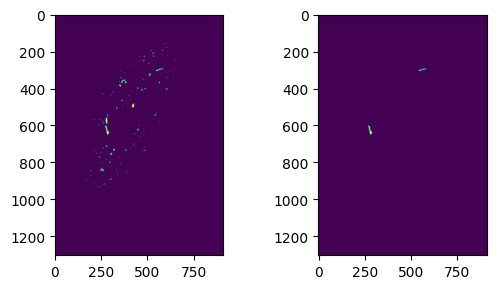

(108,
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 2805,
 2805)

In [ ]:
import cv2

mask = (masks[3] > 0).astype('uint8')
num_labels, labels_im = cv2.connectedComponents(mask)

_, axes = make_grid_plot(2, cols=2)
mask_ax, conn_ax = axes

mask_ax.imshow(mask)
conn_ax.imshow((labels_im == 64).astype('uint8') + (labels_im == 20).astype('uint8'))

plt.show()
num_labels, labels_im, mask.sum(), (labels_im != 0).sum()

In [ ]:
from torch import nn

def Swell(kernel=3):
    w = torch.ones(
        1, 1, kernel, kernel,
        dtype=torch.uint8, requires_grad=False,
        device=None,
    )

    def fn(x):
        return nn.functional.conv2d(
            x, w,
            stride=1, padding=(kernel-1)//2,
        )
    
    return fn

x = torch.tensor(masks > 0, dtype=torch.uint8)
swell_fn = Swell()

x_sum = x.sum(dim=list(range(1, x.ndim)))
selected = ((x_sum > 1000)*(x_sum < 5000)).nonzero().squeeze(dim=-1)

print(((x_sum > 1000)*(x_sum < 5000)).nonzero())
x[selected] = torch.zeros(selected.shape[0], *x.shape[1:], dtype=x.dtype)

# swell_x = swell_fn(x.unsqueeze(dim=1)).clamp(max=1).squeeze(dim=1)

x.shape, swell_x.shape, x_sum, x.sum(dim=list(range(1, swell_x.ndim))), swell_x.sum(dim=list(range(1, swell_x.ndim)))

tensor([[3],
        [6],
        [7]])


(torch.Size([10, 1303, 912]),
 torch.Size([10, 1303, 912]),
 tensor([    0,    65,   101,  2805, 15939, 12171,  4484,  4170,   604,     4]),
 tensor([    0,    65,   101,     0, 15939, 12171,     0,     0,   604,     4]),
 tensor([    0,   305,   463,  5415, 20734, 17938,  7768,  6694,  1469,    18]))

/var/folders/8y/5694n0_n42j4fmg6d5j411480000gn/T/ipykernel_48742/1400769714.py:55: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


,Mask,resize.512,resize.720,crop.128,crop.256
0,0,0,0,0,0
1,65,15,30,65,65
2,101,26,44,101,101
3,2805,609,1234,2805,2805
4,15939,3551,6940,15939,15939
5,12171,2679,5302,12171,12171
6,4484,1023,1944,4484,4484
7,4170,923,1820,4170,4170
8,604,137,264,604,604
9,4,1,3,4,4


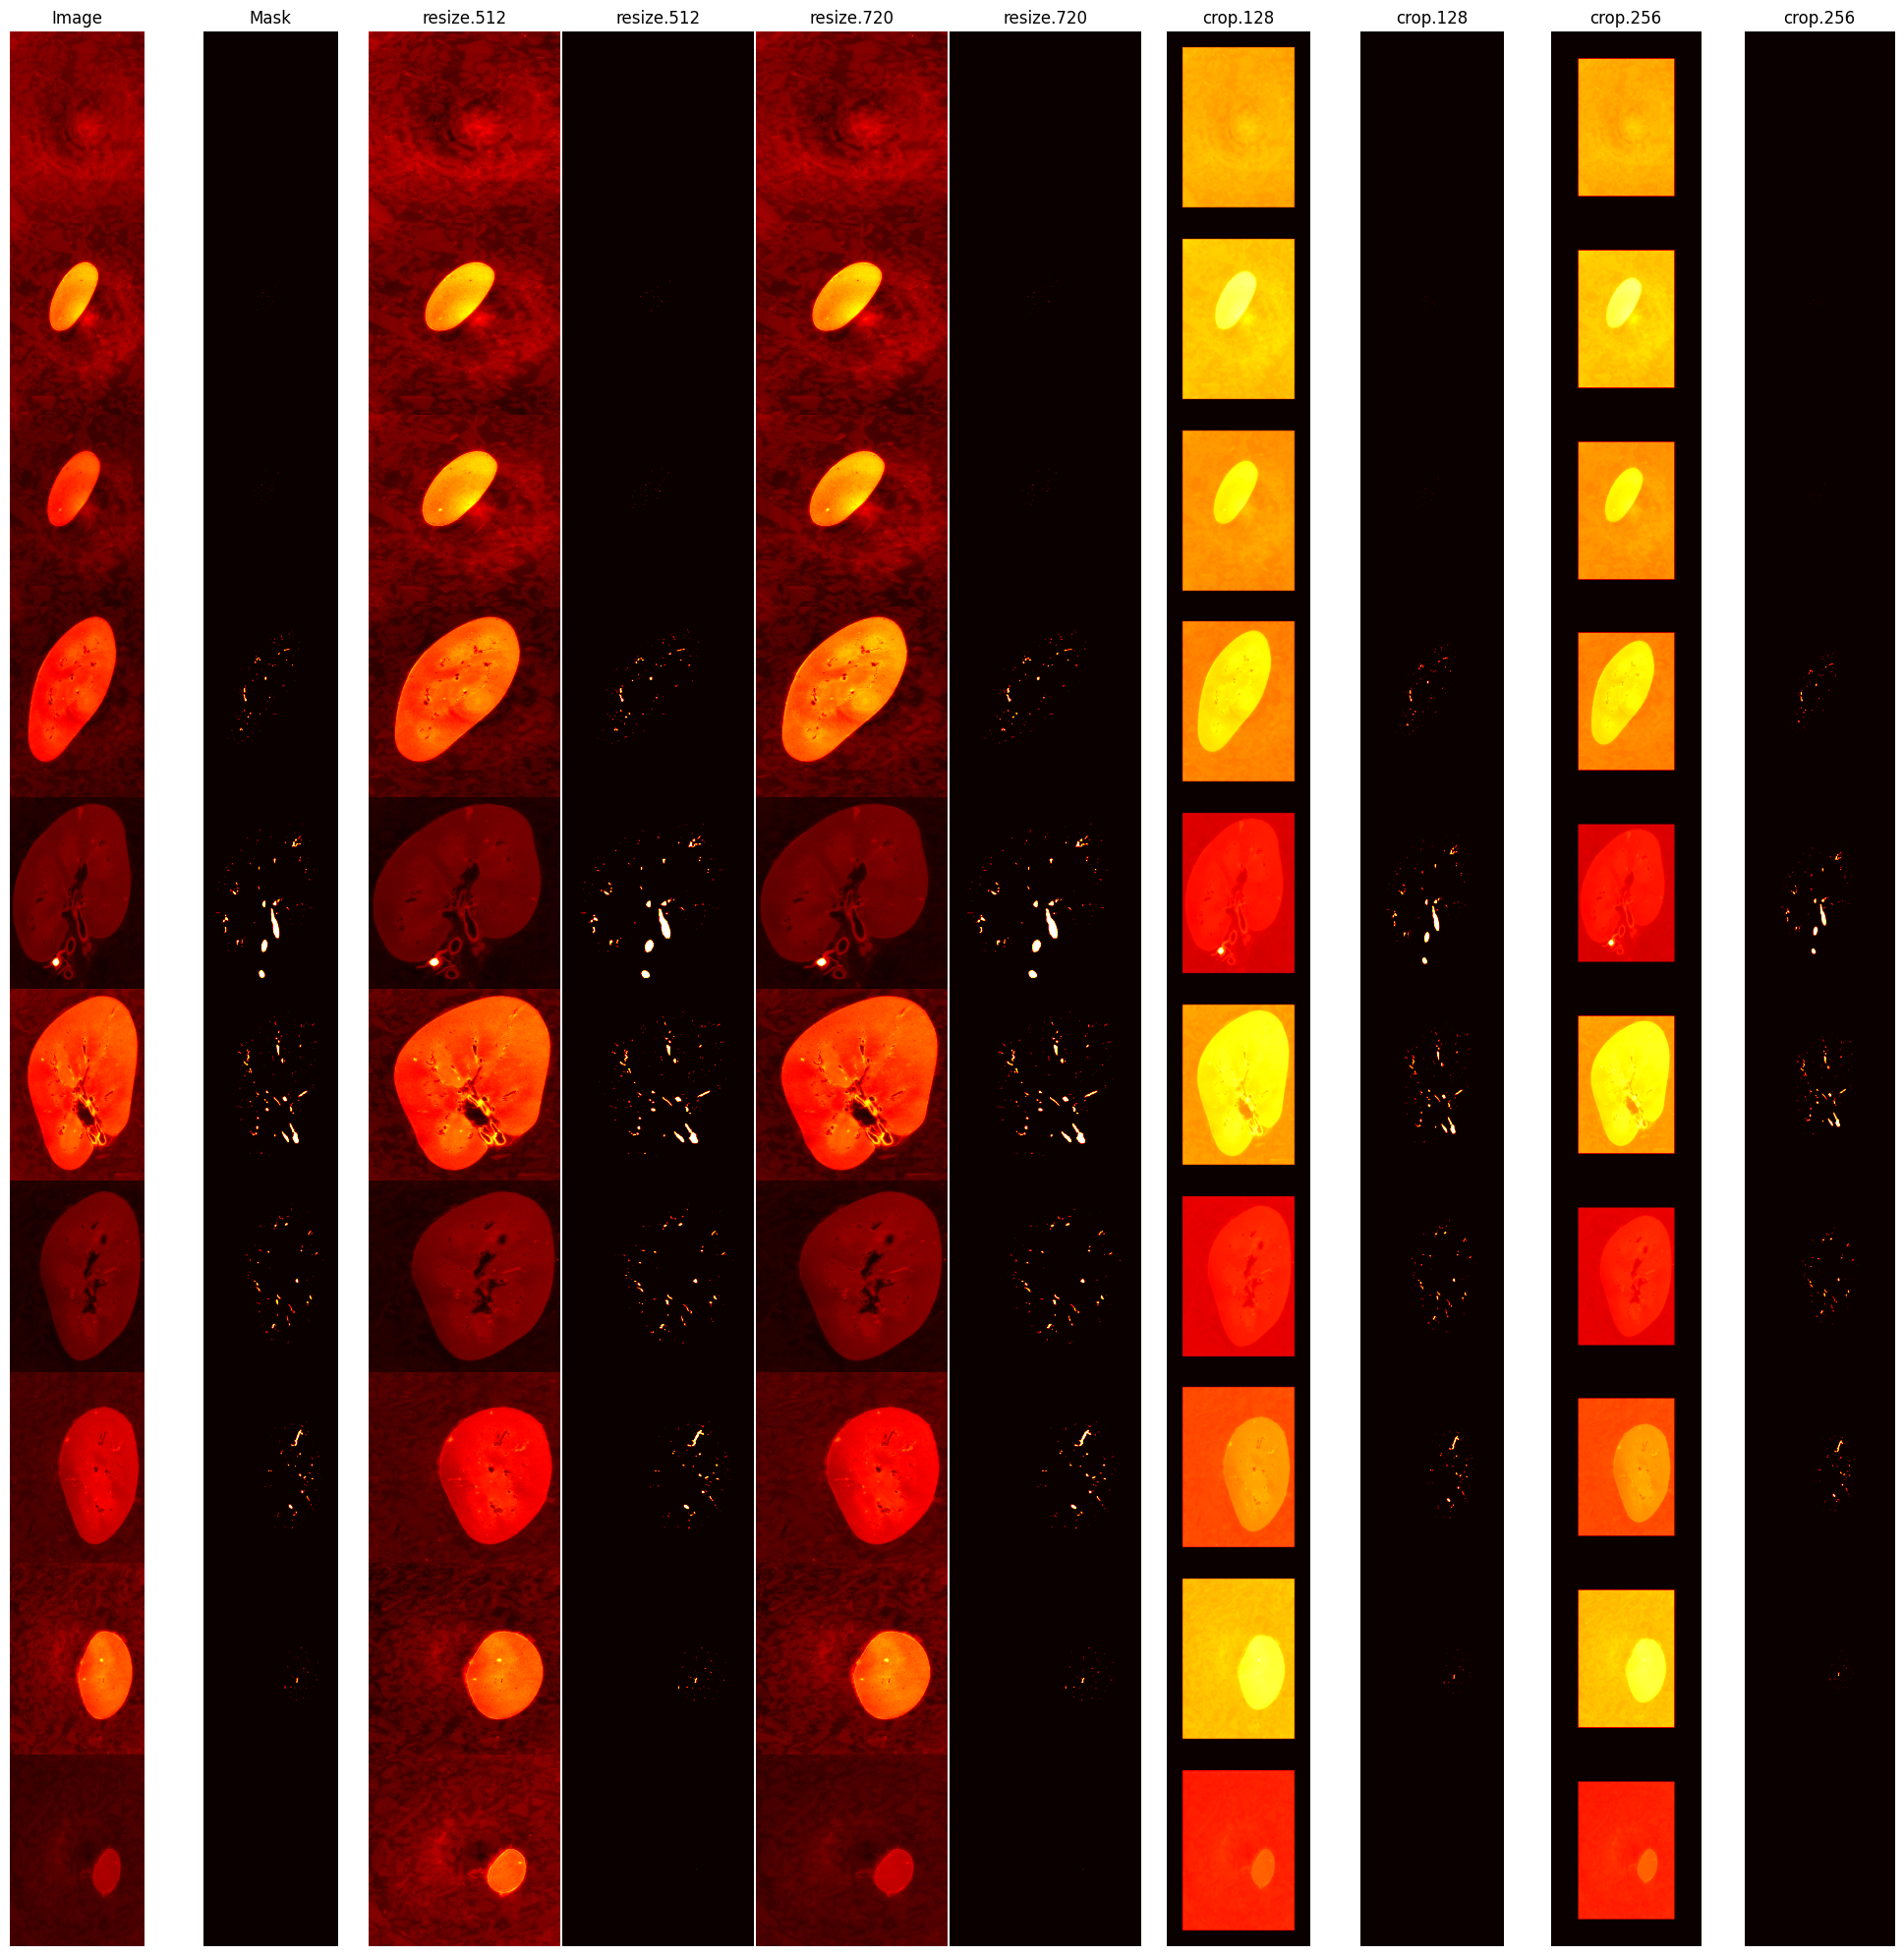

In [ ]:
import albumentations as A

from collections import OrderedDict

def get_item_fn(transforms):
    def fn(args):
        image, mask = args
        results = map(
            lambda v: (v['image'], v['mask']),
            map(
                lambda fn: fn(image=image, mask=mask),
                map(A.Compose, transforms.values())
            )
        )


        return image, mask, *itertools.chain.from_iterable(results)

    return fn

transforms = OrderedDict({
        # 'raw.float': [ToFloatImage(standardize=False)],
        # 'standard.float': [ToFloatImage()],
        # 'color.jitter': [A.ColorJitter(always_apply=True)],
        # 'gaussian.blur': [A.GaussianBlur(always_apply=True)],
        # 'invert': [A.InvertImg(always_apply=True)],
        # 'posterize': [A.Posterize(always_apply=True)],
        # 'solarize': [A.Solarize(always_apply=True)],
        # 'sharpen': [A.Sharpen(always_apply=True)],
        # 'equalize': [A.Equalize(always_apply=True)],
        # 'grid.distortion.1': [A.GridDistortion(num_steps=5, distort_limit=0.1, p=1.0)],
        # 'grid.distortion.2': [A.GridDistortion(num_steps=5, distort_limit=0.2, p=1.0)],
        # 'grid.distortion.3': [A.GridDistortion(num_steps=5, distort_limit=0.3, p=1.0)],
        # 'grid.distortion.6': [A.GridDistortion(num_steps=5, distort_limit=0.6, p=1.0)],
        # 'tonecurve.scale.1': [A.RandomToneCurve(p=1.0)],
        # 'tonecurve.scale.1': [A.RandomToneCurve(scale=.1, p=1.0)],
        # 'tonecurve.scale.2': [A.RandomToneCurve(scale=.2, p=1.0)],
        # 'tonecurve.scale.3': [A.RandomToneCurve(scale=.3, p=1.0)],
        # 'tonecurve.scale.5': [A.RandomToneCurve(scale=.5, p=1.0)],
        # 'tonecurve.scale.7': [A.RandomToneCurve(scale=.7, p=1.0)],
        # 'tonecurve.scale.9': [A.RandomToneCurve(scale=.9, p=1.0)],
        # 'version.31': [
        #     A.GridDistortion(num_steps=5, distort_limit=0.2, p=.8),
        #     A.RandomToneCurve(scale=.3, p=.8),
        # ],
        # 'motion.blur': [A.MotionBlur(p=1.0)],
        # 'crop.512': [
        #     A.RandomCrop(512, 512, always_apply=True),
        # ],
        # 'crop.768.resize.512': [
        #     A.RandomCrop(768, 768, always_apply=True),
        #     A.Resize(512, 512, always_apply=True),
        # ],
        # 'crop.256.resize.original': [
        #     A.RandomCrop(256, 256, always_apply=True),
        #     A.Resize(1303, 912, always_apply=True),
        # ],
        'resize.512': [
            A.Resize(512, 512, always_apply=True),
        ],
        'resize.720': [
            A.Resize(720, 720, always_apply=True),
        ],
        # 'center.resize.512': [
        #     A.CenterCrop(921, 644, always_apply=True),
        #     A.Resize(512, 512, always_apply=True),
        # ],
        # 'center.crop.416.resize.512': [
        #     A.CenterCrop(921, 644, always_apply=True),
        #     A.RandomCrop(362, 362, always_apply=True),
        #     A.Resize(512, 512, always_apply=True),
        # ],
        # 'shift.scale.rotate': [
        #     A.ShiftScaleRotate(border_mode=1, always_apply=True),
        #     A.Resize(512, 512, always_apply=True),
        # ],
        'crop.128': [
            A.CropAndPad(px=128, keep_size=False, always_apply=True),
        ],
        'crop.256': [
            A.CropAndPad(px=256, keep_size=False, always_apply=True),
        ]
    })

def get_item_print_fn():
    entries = []

    def fn(items):
        # stats = itertools.chain.from_iterable(map(lambda item: (item.sum(), item.clip(max=1).sum()), items[1::2]))
        stats = list(map(lambda item: item.sum(), items[1::2]))

        entries.append(stats)
        # print(*stats)

        # return items[::2]
        return items
    
    return entries, fn
    
records, item_fn = get_item_print_fn()

_ = show_items(
    np.fromiter(
        # map(get_item_fn(transforms), zip(images, map(lambda m: (m > 0).astype('uint8'), masks))),
        map(get_item_fn(transforms), zip(images, map(lambda m: (m > 0).astype('uint8'), masks))),
        dtype=object,
    ),
    titles=[
        'Image', 'Mask',
        # *transforms.keys(),
        *itertools.chain.from_iterable(
            zip(transforms.keys(), transforms.keys())
        )
    ],
    cols=2*(1+len(transforms)), size=2, cmap='hot',
    item_fn=item_fn,
)

pd.DataFrame(records, columns=['Mask', *transforms.keys()])

# _ = show_items(list(zip(images[:2], masks[:2])))

In [ ]:
import math
# image.shape, 1303-128, 912-128
math.sqrt((512*512)/2), math.sqrt((1303*1302)/2), math.sqrt((912*912)/2), 36*16, 40*16

(362.03867196751236, 921.00651463494, 644.8813844421313, 576, 640)

/var/folders/8y/5694n0_n42j4fmg6d5j411480000gn/T/ipykernel_48742/1400769714.py:55: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


(604, 582, dtype('uint8'), 0)

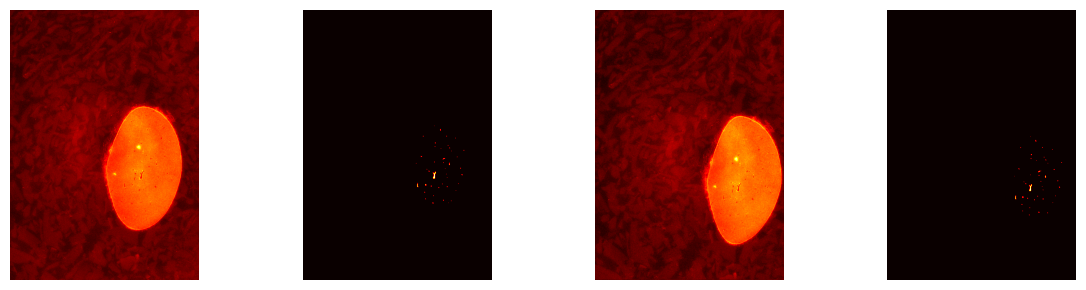

In [ ]:
item_idx = 8
image, mask = images[item_idx], masks[item_idx]

mask = (mask > 0).astype('uint8')
# result_3 = A.Compose(transforms['grid.distortion.1'])(image=image, mask=mask)
result_6 = A.Compose(transforms['grid.distortion.2'])(image=image, mask=mask)

show_items(
    # [(image, mask, result_3['image'], result_3['mask'], result_6['image'], result_6['mask'])],
    [(image, mask, result_6['image'], result_6['mask'])],
    # titles=[
    #     'Image', 'Mask',
    #     *itertools.chain.from_iterable(
    #         zip(transforms.keys(), transforms.keys())
    #     )
    # ],
    cols=4, size=3, cmap='hot',
)


# mask.sum(), result_3['mask'].sum(), result_6['mask'].sum()
mask.sum(), result_6['mask'].sum(), result_6['mask'].dtype, (result_6['mask']> 1).sum()

In [ ]:
import torchvision

from functools import reduce

def predict_item(model, config, item):
    probabilities = model(item).sigmoid()
    return (probabilities > 0.5).type(torch.uint8).squeeze(dim=1)

def prediction_chain(images_fns=[], post_fns=[], predict_fn=predict_item):
    images_fns, post_fns = images_fns, post_fns

    def fn(model, config, images):
        pp_images = reduce(lambda y,f: f(y), images_fns, images)
        predictions = predict_item(model, config, pp_images)

        return reduce(lambda y,f: f(y), post_fns, predictions)
    
    return fn

# post_process_chain()(model, config, images)
resize_fn = A.Resize(512, 512)
# x = torch.tensor(np.array(list(map(lambda image: resize_fn(image=image)['image'], images[:2])), dtype='uint8')).unsqueeze(dim=1).to(torch.float32)
x = torch.tensor(images[:2], dtype=torch.float).unsqueeze(dim=1)



prediction_chain(
    images_fns=[
        torchvision.transforms.Resize(size=(512, 512), antialias=False)
    ],
    post_fns=[
        torchvision.transforms.Resize(size=(512, 512), antialias=False)
    ]
)(model, config, x)


torch.Size([2, 1, 512, 512])


tensor([[[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 1],
         ...,
         [0, 0, 1,  ..., 1, 1, 1],
         [0, 1, 1,  ..., 1, 1, 1],
         [0, 1, 1,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 0, 0, 1],
         [0, 0, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 1,  ..., 1, 1, 1],
         [0, 0, 1,  ..., 1, 1, 1],
         [0, 1, 1,  ..., 1, 1, 1]]], dtype=torch.uint8)

In [ ]:
def create_border_mask(mask_size, border_size=32, dtype=torch.uint8):
    mask = torch.zeros(mask_size, mask_size, dtype=dtype, requires_grad=False)
    mask[border_size:mask_size-border_size,border_size:mask_size-border_size] = 1

    return mask

create_border_mask(64, 2)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 1, 0, 0],
        ...,
        [0, 0, 1,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [ ]:
from collections import defaultdict

class Metrics(object):
    def __init__(self):
        self.metrics = defaultdict(float)
        self.steps = 0

    def update(self, metrics):
        self.steps += 1

        for name,value in metrics.items():
            self.metrics[name] += value
    
    @staticmethod
    def with_key(key, name):
        return f'{key}_{name}' if key else name
    
    def compute(self, key=None):
        return dict(map(
            lambda item: (Metrics.with_key(key, item[0]), item[1]/self.steps),
            self.metrics.items()
        ))

losses = [
    {
        'focal': 2.0,
        'dice': 3.0,
        'loss': 5.0,
    },

    {
        'focal': 5.0,
        'dice': 6.0,
        'loss': 11.0,
    }
]

multiloss = Metrics()
multiloss.update(losses[0])
multiloss.update(losses[1])

multiloss.compute()

{'focal': 3.5, 'dice': 4.5, 'loss': 8.0}

In [ ]:
import pandas as pd
import numpy as np

num_epochs = 2
df = pd.DataFrame(
    [[0, 5, 2],
    [1, 2, 9],],
    columns=['epoch', 'loss', 'match_count']
)

df.groupby('epoch').agg({
    'loss': np.mean,
    'match_count': np.sum
}).eval("""
    match_rate = loss / match_count
""")

,loss,match_count,match_rate
epoch,,,
0,5.0,2,2.500000
1,2.0,9,0.222222


In [149]:
import random
import torch
import numpy as np

from PIL import Image
from torch.utils.data import Dataset
from functools import partial

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, msk_paths=[], transforms=None, channels=1, eps=1e-8):
        self.img_paths  = img_paths
        self.msk_paths  = msk_paths
        self.transforms = transforms
        self.eps = eps
        self.channels = channels
        
    def __len__(self):
        return len(self.img_paths) - self.stack + 1

    def read_image(self, index):
        # Load 16-bit TIFF image
        image = np.array(Image.open(self.img_paths[index]))
        return ((image / (self.eps + np.max(image)))*255).astype(np.uint8)
    
    def read_mask(self, index):
        # Load mask
        return np.array(
            Image.open(self.msk_paths[index]),
            dtype=bool
        ).astype(np.uint8)
    
    def __getitem__(self, index):
        images = np.stack(
            [self.read_image(index + _) for _ in range(self.channels)],
            axis=-1
        ).squeeze()

        if self.msk_paths:
            masks = np.stack(
                [self.read_mask(index + _) for _ in range(self.channels)],
                axis=-1,
            ).squeeze()
            result = self.transforms(image=images, mask=masks)
        else:
            result = self.transforms(image=images)
            
        if 'mask' in result:
            return result['image'], result['mask']
        else:
            return result['image'], images.shape[:2]

    def __repr__(self):
        # Summarize item shapes
        image, y = self[0]

        return(
            f'\nItems: {len(self)}'
            f'\nImage: {image.shape} {image.dtype}'
            f'\nHistogram: {np.histogram(image)}'
            f'\nMask: {y.shape} {y.dtype}' if self.msk_paths else ''
            f'\nHistogram: {np.histogram(y)}' if self.msk_paths else ''
            f'\nImage Shape: {y}' if not self.msk_paths else ''
        )

def MergeMaskChannels():
    def fn(**kwargs):
        mask = kwargs['mask']
        mask = mask.sum(dim=0).clamp(max=1).to(torch.uint8)
        kwargs['mask'] = mask

        return kwargs
    return fn

def Normalize(channelwise=True, eps=1e-8):
    def fn(**kwargs):
        image = kwargs['image']
        
        image = ((image - image.mean((0, 1))) / (image.std((0, 1)) + eps)).astype('float32')
            
        kwargs['image'] = image
        return kwargs
    return fn

def noop(x, **kwargs): return x

noop_transform = A.Compose([
    A.Lambda(image=noop, mask=noop)
])

vanilla_train_dataset = BuildDataset(
    image_paths,
    list(mask_paths),
    transforms=A.Compose([
        # A.Lambda(image=noop, mask=noop)
        Normalize(),
        A.CropAndPad(px=256, keep_size=False, p=0.5),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=.6),
        A.Resize(*config.input_shape, always_apply=True),
        A.HorizontalFlip(p=0.5),
        ToTensorV2(transpose_mask=True),
        MergeMaskChannels(),

    ]),
    channels=10,
    # channels=2,
)

image, mask = vanilla_train_dataset[0]
print(
    f'\n{image.shape=}'
    f'\n{mask.shape=}'
    f'\n{mask.dtype} {mask.sum()}'
)


image.shape=torch.Size([10, 512, 512])
mask.shape=torch.Size([512, 512])
torch.uint8 7497


In [144]:
np.expand_dims(images[0], -1).shape
(np.expand_dims(images[0], -1) - np.expand_dims(images[0], -1).mean(axis=(0, 1))).shape


(1303, 912, 1)